![](figs/se05.png)
# Workshop Instructions
***
- <img src="figs/icons/write.svg" width="20" style="filter: invert(41%) sepia(96%) saturate(1449%) hue-rotate(210deg) brightness(100%) contrast(92%);"/> Follow along by typing the code yourself - this helps with learning!
- <img src="figs/icons/code.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(2000%) hue-rotate(40deg) brightness(915%) contrast(100%);"/> Code cells marked as "Exercise" are for you to complete
- <img src="figs/icons/reminder.svg" width="20" style="filter: invert(100%) sepia(1500%) saturate(1500%) hue-rotate(30deg) brightness(450%) contrast(70%);"/> Look for hints if you get stuck
- <img src="figs/icons/success.svg" width="20" style="filter: invert(56%) sepia(71%) saturate(5293%) hue-rotate(117deg) brightness(95%) contrast(101%);"/> Compare your solution with the provided answers
- <img src="figs/icons/list.svg" width="20" style="filter: invert(19%) sepia(75%) saturate(6158%) hue-rotate(312deg) brightness(87%) contrast(116%);"/> Don't worry if you make mistakes - debugging is part of learning!

In [1]:
from pathlib import Path
import sys

helper_utils = Path.cwd() / "utils"
sys.path.append(str(helper_utils))

import utils
import inspect 
from torchvision import transforms
from PIL import Image
import random
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
torch.manual_seed(101)
torch.cuda.manual_seed(101)
random.seed(101)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

checker = utils.core.ExerciseChecker("SE05")
quizzer = utils.core.QuizManager("SE05")

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Faculty of Science and Engineering 🔬
The University of Manchester 
Invoking utils version: 1.0.0+99d9508
Using device: cuda


# 1. Introduction to Transfer Learning
***
> <img src="figs/icons/write.svg" width="20" style="filter: invert(41%) sepia(96%) saturate(1449%) hue-rotate(210deg) brightness(100%) contrast(92%);"/> **Definition**: Transfer learning is a machine learning technique where a model developed for one task is reused as a starting point for a model on a second task. It's particularly effective for deep learning models, as it allows us to leverage pre-trained models' knowledge rather than starting from scratch.

In previous sessions, we learned how to build and train neural networks from scratch. However, training large deep learning models requires:

1. **Massive datasets** (often millions of examples)
2. **Extensive computational resources** (often multiple GPUs)
3. **Long training times** (days to weeks)

Transfer learning addresses these challenges by letting us capitalise on existing models that have already been trained on large datasets.

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <img src="figs/transfer.png" alt="Transfer Learning Concept" style="width: 50%; height: auto; margin: 0 auto;">
</figure>

## 1.1 Transfer Learning Analogy
***

Transfer learning is inspired by human learning. Consider how we learn:

| Human Learning | Machine Learning Parallel |
|----------------|--------------------------|
| A child learns to recognize basic shapes before identifying letters | A model learns edge detection before specific object recognition |
| A musician who knows piano can learn guitar faster than a novice | A model trained on one image dataset can adapt quickly to a similar task |
| Language skills transfer across related languages (e.g., Spanish to Italian) | NLP models pre-trained on one language can be fine-tuned for another |
| Medical students learn general anatomy before specializing | Medical imaging models trained on general X-rays can be fine-tuned for specific conditions |
| Engineers apply fundamental principles across different projects | Engineering models transfer physical principles across different applications |

This mirrors how neural networks learn hierarchical features. Early layers learn general patterns that are often applicable across domains, while later layers learn task-specific features.


## 1.2 When to Use Transfer Learning
***

Transfer learning is particularly useful in the following scenarios:

| Scenario | Example | Benefit |
|----------|---------|---------|
| **Limited training data** | Medical imaging with few samples | Pre-trained features compensate for data scarcity |
| **Similar domains** | From natural images to satellite imagery | Underlying features (edges, textures) transfer well |
| **Time constraints** | Rapid prototyping needs | Accelerates model development cycle |
| **Hardware limitations** | Training with limited GPU access | Reduces computational requirements |
| **Preventing overfitting** | Small dataset applications | Regularization effect from pre-trained weights |
***
> <img src="figs/icons/reminder.svg" width="20" style="filter: invert(100%) sepia(1500%) saturate(1500%) hue-rotate(30deg) brightness(450%) contrast(70%);"/> **Key Insight**: The effectiveness of transfer learning depends on the similarity between the source and target domains. The more similar they are, the more beneficial transfer learning becomes.


In [2]:
# Quiz on Transfer Learning Concepts
print("\n🧠 Quiz 1: Transfer Learning Applications")
quizzer.run_quiz(1)


🧠 Quiz 1: Transfer Learning Applications
--------------------------------------------------------------------------------
📋 Transfer Learning Applications Quiz
--------------------------------------------------------------------------------
In which engineering scenario would transfer learning provide the MOST significant advantage?

A. When you have a simple classification problem with millions of labeled examples

B. When you need to detect defects in industrial parts but only have 200 labeled images

C. When you're building a model to predict well-documented physical properties

D. When computational efficiency isn't a concern and you have months to train a model from scratch


❌ Incorrect. The correct answer is B.

📚 Explanation:
Transfer learning provides a major advantage for engineering applications by
allowing knowledge learned from one task to be applied to a different but
related task. This approach significantly reduces the amount of training data
required and accelerates t

# 2. Case Study: Image Segmentation for Medical Imaging
***
> <img src="figs/icons/write.svg" width="20" style="filter: invert(41%) sepia(96%) saturate(1449%) hue-rotate(210deg) brightness(100%) contrast(92%);"/> **Image Segmentation**: The process of partitioning an image into multiple segments or regions, often used in medical imaging to identify and delineate structures within images (e.g., tumors, organs). It is a crucial step in many computer vision tasks, including object detection and recognition.

For this session, we are going to be using the [**ISIC 2016 Skin Lesion Segmentation Challenge**](https://challenge.isic-archive.com/landing/2016/) dataset. This dataset contains dermoscopic images of skin lesions, along with their corresponding segmentation masks. The goal is to train a model to accurately segment the lesions from the background.

In [3]:
data_path = Path(Path.cwd(), 'datasets')
dataset_path = utils.data.download_dataset('skin lesions',
                                           dest_path=data_path,
                                           extract=True,
                                           remove_compressed=False)

mask_path = utils.data.download_dataset('skin lesions masks',
                                   dest_path=data_path,
                                   extract=True,
                                   remove_compressed=False)

test_path = utils.data.download_dataset('skin lesions test',
                                   dest_path=data_path,
                                   extract=True,
                                   remove_compressed=False)

test_mask_path = utils.data.download_dataset('skin lesions test masks',
                                   dest_path=data_path,
                                   extract=True,
                                   remove_compressed=False)

Downloading:
Skin Lesion Analysis Towards Melanoma Detection
> Authors: Tschandl, P., Rosendahl, C., Kittler, H.
> Year: 2016
> Website: https://challenge.isic-archive.com/data

File already exists


Extracting ISBI2016_ISIC_Part1_Training_Data.zip: 100%|██████████| 900/900 [00:01<00:00, 685.72it/s] 


Downloading:
Skin Lesion Analysis Towards Melanoma Detection Masks
> Authors: Tschandl, P., Rosendahl, C., Kittler, H.
> Year: 2016
> Website: https://challenge.isic-archive.com/data

File already exists


Extracting ISBI2016_ISIC_Part1_Training_GroundTruth.zip: 100%|██████████| 900/900 [00:00<00:00, 1628.74it/s]


Downloading:
Skin Lesion Analysis Towards Melanoma Detection Test Data
> Authors: Tschandl, P., Rosendahl, C., Kittler, H.
> Year: 2016
> Website: https://challenge.isic-archive.com/data

File already exists


Extracting ISBI2016_ISIC_Part1_Test_Data.zip: 100%|██████████| 379/379 [00:00<00:00, 652.45it/s] 


Downloading:
Skin Lesion Analysis Towards Melanoma Detection Test Masks
> Authors: Tschandl, P., Rosendahl, C., Kittler, H.
> Year: 2016
> Website: https://challenge.isic-archive.com/data

File already exists


Extracting ISBI2016_ISIC_Part1_Test_GroundTruth.zip: 100%|██████████| 379/379 [00:00<00:00, 2164.02it/s]


## 2.1 Challenges in Medical Image Segmentation
***

Medical image segmentation presents unique challenges compared to natural image segmentation:

| Challenge | Description | Impact |
|-----------|-------------|--------|
| **Limited Data** | Medical datasets are typically smaller | Transfer learning becomes crucial |
| **Class Imbalance** | Regions of interest often occupy a small portion of the image | Requires specialized loss functions |
| **Ambiguous Boundaries** | Boundaries between tissues can be gradual or unclear | Makes precise segmentation difficult |
| **Inter-observer Variability** | Different experts may segment the same image differently | Ground truth is not always definitive |
| **High Stakes** | Errors can have serious consequences in medical applications | Demands higher accuracy and reliability |

# 3. Preparing the Dataset
***
Segmentation tasks require both the input images and their corresponding masks. The masks are binary images where the pixels belonging to the object of interest (e.g., a tumor) are marked as 1 (or white), while the background is marked as 0 (or black). Thus, we need to load both the images and their masks for training.

## 3.1 Custom Dataset Creation
***

In order for us to efficiently load the images and masks, we are going to create a custom dataset class. This class will inherit from the `torch.utils.data.Dataset` class and will handle loading the images and masks from the specified directories.

The PyTorch `Dataset` class is an abstract class representing a dataset. Custom datasets should inherit from this class and override the following methods:

| Method | Purpose | Implementation Requirements |
|--------|---------|------------------------------|
| `__init__` | Initialize the dataset | Define directories, transformations, and data loading parameters |
| `__len__` | Return dataset size | Return the total number of samples |
| `__getitem__` | Access a specific sample | Load and transform a sample with a given index |

For image segmentation, our dataset needs to handle both input images and their corresponding segmentation masks:

***
> <img src="figs/icons/code.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(2000%) hue-rotate(40deg) brightness(915%) contrast(100%);"/> **Snippet 1**: Create a custom dataset class for loading

``` python
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, **kwargs):
        """
        Initializes the dataset, loading the images and masks from the specified directories.
        """
    
    def __len__(self):
        """
        Returns the number of images in the dataset.
        """
    
    def __getitem__(self, idx):
        """
        Defines how to get a single item (image and mask) from the dataset.
        
```

In [4]:
# Exercise 1: Creating a Custom Dataset 🎯
# Implement: 
# 1. Create a custom dataset class for the ISIC dataset.
# 2. Implement the __len__ and __getitem__ methods.
# 3. Use the PIL library to read images and masks.
# 4. Apply transformations to images and masks if provided.

from torch.utils.data import Dataset, DataLoader

class ISICDataset(Dataset):
    def __init__(self, image_dir: Path | str, mask_dir: Path | str, img_transform=None, mask_transform=None):
        self.image_dir = Path(image_dir)
        self.mask_dir = Path(mask_dir)
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        self.images = sorted(self.image_dir.glob("*.jpg"))
        self.masks = sorted(self.mask_dir.glob("*.png"))

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = self.image_dir / img_name
        mask_name = str(img_name.stem + "_segmentation.png")
        mask_path = self.mask_dir / mask_name

        image = Image.open(img_path).convert("RGB") # Convert to RGB
        mask = Image.open(mask_path).convert("L") # Convert to grayscale since it's a binary mask

        # Apply transformations if provided
        if self.img_transform:
            image = self.img_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        
        return image, mask

resize_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

ds = ISICDataset(
    image_dir=dataset_path,
    mask_dir=mask_path,
    img_transform=resize_transform,
    mask_transform=resize_transform
)


In [5]:
# ✅ Check Exercise 1: Custom Dataset Implementation
answer = {
    'has_getitem': hasattr(ISICDataset, '__getitem__'),
    'has_len': hasattr(ISICDataset, '__len__'),
    'dataset_instance': ds,
    'img_transform_used': hasattr(ds, 'img_transform') and ds.img_transform is not None,
    'mask_transform_used': hasattr(ds, 'mask_transform') and ds.mask_transform is not None
}
checker.check_exercise(1, answer)

--------------------------------------------------------------------------------
✅ has_getitem is correct!
✅ has_len is correct!
✅ dataset_instance is correct!
✅ img_transform_used is correct!
✅ mask_transform_used is correct!

🎉 Excellent! All parts are correct!


## 3.2 Compute the Mean and Standard Deviation of the Dataset
***

Computing dataset statistics is a critical step in preparing data for deep learning models. We need to normalize our images to help the model converge faster and perform better. By normalizing with the dataset's mean and standard deviation, we ensure that the input values have similar scales and distributions.

The normalisation process follows this formula for each channel:

$$x_{normalized} = \frac{x - \mu}{\sigma}$$

Where:
- $x$ is the original pixel value
- $\mu$ is the mean of all pixels in the channel across the dataset
- $\sigma$ is the standard deviation of all pixels in the channel across the dataset

First, we need to load the dataset and then compute the mean and standard deviation across all images.

In [6]:
# Exercise 2: Calculating Mean and Std of Images 🎯
# Implement:
# 1. Create a DataLoader for the dataset.
# 2. Iterate through the DataLoader to calculate the mean and standard deviation of the images.

from tqdm import tqdm

dl = DataLoader(ds, batch_size=16, shuffle=False)

n_channels = 3
n_pixels = 0
channel_sum = torch.zeros(n_channels)
channel_squared_sum = torch.zeros(n_channels)

for images, _ in tqdm(dl, desc="Calculating mean and std"):
    images = images.view(images.size(0), images.size(1), -1)  # (B, C, H*W)
    n_pixels += images.size(0) * images.size(2)

    channel_sum += images.sum(dim=[0, 2])        # Sum over batch and pixels
    channel_squared_sum += (images ** 2).sum(dim=[0, 2])

# Calculate mean and std
mean = channel_sum / n_pixels
std = (channel_squared_sum / n_pixels - mean**2).sqrt()

print("Mean:", mean)
print("Std:", std)

Calculating mean and std: 100%|██████████| 57/57 [00:21<00:00,  2.66it/s]

Mean: tensor([0.7239, 0.6187, 0.5673])
Std: tensor([0.1625, 0.1694, 0.1897])


In [7]:
# ✅ Check Exercise 2: Mean and Standard Deviation Calculation
answer = {
    'dataloader': dl,
    'mean_shape': mean.shape,
    'std_shape': std.shape,
    'mean_range': torch.all((mean >= 0) & (mean <= 1)).item(),
    'std_range': torch.all((std > 0) & (std < 1)).item()
}
checker.check_exercise(2, answer)

--------------------------------------------------------------------------------
✅ dataloader is correct!
✅ mean_shape is correct!
✅ std_shape is correct!
✅ mean_range is correct!
✅ std_range is correct!

🎉 Excellent! All parts are correct!


## 3.3 Data Augmentation
***
We are going to use the albumentations library for data augmentation. This library outperforms the torchvision library in terms of speed and flexibility. It provides the same transformations as torchvision and it is also compatible with PyTorch.

### 3.3.1 Choosing Appropriate Augmentations for Medical Images

| Augmentation Type | Purpose | Medical Imaging Considerations |
|-------------------|---------|-------------------------------|
| **Geometric Transforms** | Rotate, flip, resize | Should preserve diagnostic features |
| **Color Adjustments** | Brightness, contrast, saturation | Use carefully to maintain diagnostic appearance |
| **Noise Addition** | Add random noise | Models will be more robust to image noise |
| **Elastic Deformations** | Simulate tissue deformation | Especially useful for soft tissue imaging |
| **Cropping** | Focus on different regions | Ensures focus on different areas of lesion |

### 3.3.2 Sync vs. Async Augmentation

For segmentation tasks, we need to ensure that the same transformations are applied to both the image and its corresponding mask. This is called synchronized (sync) augmentation, as opposed to asynchronous (async) augmentation where different transformations are applied to inputs and targets.

| Type | Description | Use Case |
|------|-------------|----------|
| **Sync Augmentation** | Apply identical spatial transforms to image and mask | Required for segmentation tasks |
| **Async Augmentation** | Apply different transforms | Typically used for classification only |
***
> <img src="figs/icons/reminder.svg" width="20" style="filter: invert(100%) sepia(1500%) saturate(1500%) hue-rotate(30deg) brightness(450%) contrast(70%);"/> **Important**: When augmenting for segmentation tasks, always ensure that geometric transformations (flips, rotations, etc.) are applied identically to both the image and its mask to maintain pixel-to-pixel correspondence.
***
> <img src="figs/icons/code.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(2000%) hue-rotate(40deg) brightness(915%) contrast(100%);"/> **Snippet 2**: Using albumentations for data augmentation

``` python
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=mean, std=std, p=1.0),
    ToTensorV2()
])
```

In [8]:
# Exercise 3: Data Augmentation with Albumentations 🎯
# Implement:
# 1. Use the Albumentations library to apply data augmentation techniques.
# 2. Create a transformation pipeline for training and validation datasets.
# 3. The training pipeline should include:
#    - Resize to 64x64
#    - Random horizontal and vertical flips
#    - Random rotation (limit 10 degrees)
#    - Random brightness, contrast, saturation, and hue adjustments
#    - Normalization using the calculated mean and std
# 4. The validation pipeline should include:
#    - Resize to 64x64
#    - Normalization using the calculated mean and std
# 5. All transformations should convert images to PyTorch tensors.

import albumentations as A
from albumentations.pytorch import ToTensorV2

train_img_ts = A.Compose([
    A.Resize(64, 64),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=10,p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.Normalize(mean=mean, std=std, p=1.0),
    ToTensorV2()
])

valid_img_ts = A.Compose([
    A.Resize(64, 64),
    A.Normalize(mean=mean, std=std, p=1.0),
    ToTensorV2()
])


In [9]:
# ✅ Check Exercise 3: Data Augmentation with Albumentations
answer = {
    'train_transforms': train_img_ts,
    'valid_transforms': valid_img_ts,
    'has_resize': any(isinstance(t, A.Resize) for t in train_img_ts.transforms),
    'has_horizontal_flip': any(isinstance(t, A.HorizontalFlip) for t in train_img_ts.transforms),
    'has_vertical_flip': any(isinstance(t, A.VerticalFlip) for t in train_img_ts.transforms),
    'has_rotation': any(isinstance(t, A.Rotate) for t in train_img_ts.transforms),
    'has_color_jitter': any(isinstance(t, A.ColorJitter) for t in train_img_ts.transforms),
    'has_normalize': any(isinstance(t, A.Normalize) for t in train_img_ts.transforms),
    'has_to_tensor': any(isinstance(t, ToTensorV2) for t in train_img_ts.transforms)
}
checker.check_exercise(3, answer)

--------------------------------------------------------------------------------
✅ train_transforms is correct!
✅ valid_transforms is correct!
✅ has_resize is correct!
✅ has_horizontal_flip is correct!
✅ has_vertical_flip is correct!
✅ has_rotation is correct!
✅ has_color_jitter is correct!
✅ has_normalize is correct!
✅ has_to_tensor is correct!

🎉 Excellent! All parts are correct!


### 3.3.4 Modifying the Dataset Class to use Albumentations
***
Since normal PyTorch transforms do not support the synchronized augmentation, we need to modify our dataset class to use albumentations. We will also add the normalization step in the `__getitem__` method.

We are going to create a new class called that inherits from our `ISICDataset` class. This will allow us to override the `__getitem__` method and apply the albumentations transformations.

In [10]:
# Exercise 4: Implementing the Albumentations Dataset Class 🎯
# Implement:
# 1. Inherit from the ISICDataset class.
# 2. Override the __getitem__ method to apply Albumentations transformations.
# 3. Ensure the mask is binary (0 or 1) 

class ISICDatasetAlbumentations(ISICDataset):
    def __init__(self, image_dir: Path | str, mask_dir: Path | str, transform=None):
        super().__init__(image_dir, mask_dir, transform, None)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = self.image_dir / img_name
        mask_name = str(img_name.stem + "_segmentation.png")
        mask_path = self.mask_dir / mask_name

        image = Image.open(img_path).convert("RGB") # Convert to RGB
        image = np.array(image)  # Convert to numpy array for albumentations
        mask = Image.open(mask_path).convert("L") # Convert to grayscale since it's a binary mask
        mask = np.array(mask)

        # Normalize mask to 0-1 range if it's not already
        if mask.max() > 1:
            mask = mask / 255.0

        # Apply transformations if provided
        if self.img_transform:
            aug = self.img_transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']
            
            # Ensure mask is binary (0 or 1)
            if isinstance(mask, torch.Tensor):
                mask = (mask > 0.5).float()

        return image, mask

In [11]:
# ✅ Check Exercise 4: Albumentations Dataset Implementation
answer = {
    'inherits_from_isic': issubclass(ISICDatasetAlbumentations, ISICDataset),
    'has_getitem_override': ISICDatasetAlbumentations.__getitem__ != ISICDataset.__getitem__,
    'uses_numpy': 'np.array' in str(inspect.getsource(ISICDatasetAlbumentations.__getitem__)),
    'normalizes_mask': 'mask /' in str(inspect.getsource(ISICDatasetAlbumentations.__getitem__)),
    'ensures_binary': '> 0.5' in str(inspect.getsource(ISICDatasetAlbumentations.__getitem__))
}
checker.check_exercise(4, answer)

--------------------------------------------------------------------------------
✅ inherits_from_isic is correct!
✅ has_getitem_override is correct!
✅ uses_numpy is correct!
✅ normalizes_mask is correct!
✅ ensures_binary is correct!

🎉 Excellent! All parts are correct!


# 3.4 Splitting the Dataset into Train, and Validation Sets
***
Unfortunately, PyTorch `Dataset` class does not have a built-in method for splitting datasets. However, we can use the `torch.utils.data.random_split` function to split our dataset into training and validation sets. Then, we can create separate `DataLoader` instances for each split.

> <img src="figs/icons/code.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(2000%) hue-rotate(40deg) brightness(915%) contrast(100%);"/> **Snippet 3**: Splitting the dataset into training and validation sets

``` python
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [train_size, val_size])
```

In [12]:
# Exercise 5: Splitting the Dataset into Train and Validation Sets 🎯
# Implement:
# 1. Split the dataset into training and validation sets (80% train, 20% valid).
# 2. Create DataLoader objects for both sets with a batch size of 16.

full_ds = ISICDatasetAlbumentations(
    image_dir=dataset_path,
    mask_dir=mask_path,
    transform=train_img_ts
)

train_size = int(0.8 * len(full_ds))
valid_size = len(full_ds) - train_size
train_ds, valid_ds = torch.utils.data.random_split(full_ds, [train_size, valid_size])

train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=16, shuffle=False)

In [13]:
# ✅ Check Exercise 5: Dataset Splitting
answer = {
    'train_dataset': train_ds,
    'valid_dataset': valid_ds,
    'train_dataloader': train_dl,
    'valid_dataloader': valid_dl,
    'train_split_ratio': train_size / len(full_ds),
    'batch_size_correct': train_dl.batch_size == 16
}
checker.check_exercise(5, answer)

--------------------------------------------------------------------------------
✅ train_dataset is correct!
✅ valid_dataset is correct!
✅ train_dataloader is correct!
✅ valid_dataloader is correct!
✅ train_split_ratio is correct!
✅ batch_size_correct is correct!

🎉 Excellent! All parts are correct!


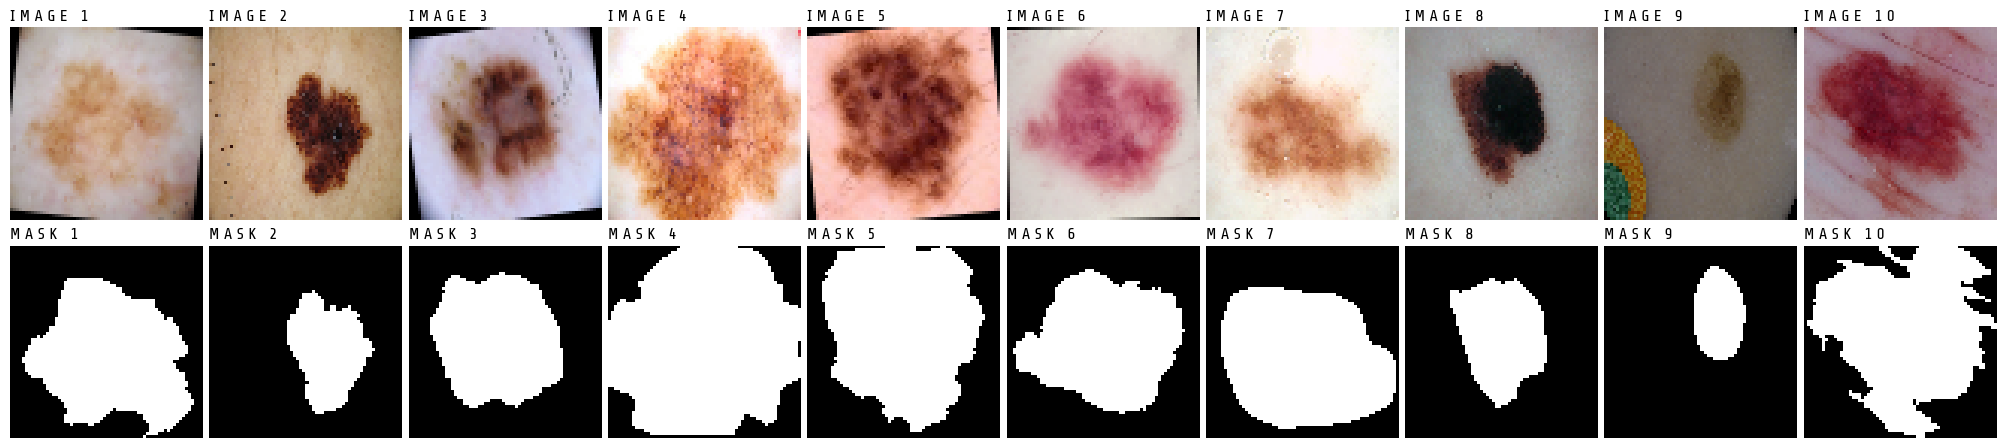

In [14]:
# Show a batch of images and masks
utils.plotting.show_binary_segmentation_batch(train_dl,
                                              n_images=10,
                                              mean=mean,
                                              std=std)

# 4. Baseline Model: U-Net Architecture
***
> <img src="figs/icons/write.svg" width="20" style="filter: invert(41%) sepia(96%) saturate(1449%) hue-rotate(210deg) brightness(100%) contrast(92%);"/> **U-Net**: A convolutional neural network architecture designed for biomedical image segmentation. It consists of a contracting path (encoder) and an expansive path (decoder), allowing it to capture both context and localization information.

The U-Net architecture is widely used in medical image segmentation tasks due to its ability to learn both local and global features. The architecture is shown below:

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <img src="figs/unet.png" alt="U-Net Architecture" style="width: 100%; height: auto; margin: 0 auto;">
</figure>


The U-Net architecture consists of two main parts: the encoder and the decoder, connected by skip connections. Each component plays a specific role:

| Component | Description | Purpose |
|-----------|-------------|---------|
| **Encoder (Contracting Path)** | Series of convolutional and pooling layers | Captures context and semantic information |
| **Decoder (Expanding Path)** | Series of upsampling and convolutional layers | Enables precise localization |
| **Skip Connections** | Connect encoder layers to decoder layers | Preserve spatial information lost during downsampling |
| **Bottleneck** | Deepest layer connecting encoder and decoder | Captures the most complex features |

## 4.1 Transposed Convolution
***

For this architecture we are going to use a special type of convolutional layer that upsamples the input feature maps. This layer is called a transposed convolutional layer (also known as a deconvolutional layer). It is used to increase the spatial dimensions of the input feature maps, allowing the model to learn more complex features.

| Parameter | Description | Effect on Output |
|-----------|-------------|-----------------|
| **Kernel Size** | Size of the filter | Determines area of influence |
| **Stride** | Step size of the filter | Controls amount of upsampling |
| **Padding** | Zero-padding added to input | Affects output size |
| **Output Padding** | Additional padding for output | Fine-tunes output dimensions |

The formula for calculating the output size of a transposed convolutional layer is:

$$\text{Output Size} = (\text{Input Size} - 1) \times \text{Stride} - 2 \times \text{Padding} + \text{Kernel Size} + \text{Output Padding}$$

## 4.2 U-Net Implementation in PyTorch
***
We are going to implement the U-Net architecture using PyTorch. The implementation will consist of the following components:

| Component | Description |
|----------|-------------|
| `DoubleConv` | A block that consists of two convolutional layers followed by batch normalization and ReLU activation. |
| `Down` | A block that consists of a max pooling layer followed by a `DoubleConv` block. |
| `Up` | A block that consists of a transposed convolutional layer followed by a `DoubleConv` block. |
| `UNet` | The main U-Net architecture that consists of the encoder and decoder blocks. |

In [15]:
# Exercise 6: Implementing the DoubleConv Block 🎯
# Implement:
# 1. Create a class called DoubleConv that inherits from nn.Module.
# 2. The constructor should take in the number of input channels and output channels.
# 3. Implement the forward method to apply two convolutional layers with ReLU activation and batch normalization.
# 4. Use kernel size 3 and padding 1 for both convolutional layers.
class DoubleConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


In [16]:
# ✅ Check Exercise 6: DoubleConv Block Implementation
answer = {
    'has_forward': hasattr(DoubleConv, 'forward'),
    'has_two_conv_layers': str(DoubleConv(3, 64)).count('Conv2d') == 2,
    'has_batch_norm': str(DoubleConv(3, 64)).count('BatchNorm2d') == 2,
    'has_relu': str(DoubleConv(3, 64)).count('ReLU') == 2,
    'uses_sequential': hasattr(DoubleConv(3, 64), 'conv') and isinstance(DoubleConv(3, 64).conv, torch.nn.Sequential)
}
checker.check_exercise(6, answer)

--------------------------------------------------------------------------------
✅ has_forward is correct!
✅ has_two_conv_layers is correct!
✅ has_batch_norm is correct!
✅ has_relu is correct!
✅ uses_sequential is correct!

🎉 Excellent! All parts are correct!


In [17]:
# Exercise 7: Implementing the Down Block 🎯
# Implement:
# 1. Create a class called Down that inherits from nn.Module.
# 2. The constructor should take in the number of input channels and output channels.
# 3. Implement the forward method to apply a max pooling layer followed by the DoubleConv block.
# 4. Use a kernel size of 2 for the max pooling layer and stride of 2.
class Down(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = torch.nn.Sequential(
            torch.nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [18]:
# ✅ Check Exercise 7: Down Block Implementation
answer = {
    'has_forward': hasattr(Down, 'forward'),
    'has_maxpool': str(Down(3, 64)).count('MaxPool2d') == 1,
    'uses_doubleconv': str(Down(3, 64)).count('DoubleConv') == 1,
    'uses_sequential': hasattr(Down(3, 64), 'maxpool_conv') and isinstance(Down(3, 64).maxpool_conv, torch.nn.Sequential)
}
checker.check_exercise(7, answer)

--------------------------------------------------------------------------------
✅ has_forward is correct!
✅ has_maxpool is correct!
✅ uses_doubleconv is correct!
✅ uses_sequential is correct!

🎉 Excellent! All parts are correct!


In [19]:
# Exercise 8: Implementing the Up Block 🎯
# Implement:
# 1. Create a class called Up that inherits from nn.Module.
# 2. The constructor should take in the number of input channels and output channels.
# 3. Implement the forward method to apply a transposed convolution followed by the DoubleConv block.
# 4. Use a kernel size of 2 and stride of 2 for the transposed convolution.
# 5. Ensure to concatenate the feature maps from the encoder and decoder paths.
# 6. Handle the case where the sizes of the feature maps do not match by padding.
# 7. Use the torch.functional.pad function to pad the feature maps before concatenation.

class Up(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = torch.nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # Padding if needed for sizes to match
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = torch.nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2, 
                        diffY // 2, diffY - diffY // 2])
        
        # Concatenate along the channel dimension
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [20]:
# ✅ Check Exercise 8: Up Block Implementation
answer = {
    'has_forward': hasattr(Up, 'forward'),
    'has_transpose_conv': hasattr(Up(64, 32), 'up') and isinstance(Up(64, 32).up, torch.nn.ConvTranspose2d),
    'uses_doubleconv': hasattr(Up(64, 32), 'conv') and isinstance(Up(64, 32).conv, DoubleConv),
    'handles_size_mismatch': 'diffY' in str(inspect.getsource(Up.forward)),
    'uses_concat': 'torch.cat' in str(inspect.getsource(Up.forward))
}
checker.check_exercise(8, answer)

--------------------------------------------------------------------------------
✅ has_forward is correct!
✅ has_transpose_conv is correct!
✅ uses_doubleconv is correct!
✅ handles_size_mismatch is correct!
✅ uses_concat is correct!

🎉 Excellent! All parts are correct!


In [21]:
# Exercise 9: Implementing the UNet Model 🎯
# Implement:
# 1. Create a class called UNet that inherits from nn.Module.
# 2. The constructor should take in the number of input channels and output channels.
# 3. Implement the forward method to define the architecture of the UNet model.
# 4. Use the DoubleConv, Down, and Up classes to build the encoder and decoder paths.
# 5. Ensure to include skip connections between the encoder and decoder paths.
# 6. Use a final convolutional layer to produce the output.
# 7. Use a kernel size of 1 for the final convolutional layer.
# 8. Apply a sigmoid activation function to the output layer.

class UNet(torch.nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        
        # Initial convolution
        self.inc = DoubleConv(in_channels, 64)
        
        # Encoder path
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        
        # Decoder path
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        
        # Output layer
        self.outc = torch.nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # Decoder with skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        # Output layer
        output = self.outc(x)
        return torch.nn.functional.sigmoid(output)


In [22]:
# ✅ Check Exercise 9: UNet Model Implementation
answer = {
    'has_forward': hasattr(UNet, 'forward'),
    'has_encoder_path': hasattr(UNet(3, 1), 'inc') and hasattr(UNet(3, 1), 'down1'),
    'has_decoder_path': hasattr(UNet(3, 1), 'up1') and hasattr(UNet(3, 1), 'up4'),
    'has_final_conv': hasattr(UNet(3, 1), 'outc') and isinstance(UNet(3, 1).outc, torch.nn.Conv2d),
    'uses_sigmoid': 'sigmoid' in str(inspect.getsource(UNet.forward))
}
checker.check_exercise(9, answer)

--------------------------------------------------------------------------------
✅ has_forward is correct!
✅ has_encoder_path is correct!
✅ has_decoder_path is correct!
✅ has_final_conv is correct!
✅ uses_sigmoid is correct!

🎉 Excellent! All parts are correct!


## 4.3 Segmentation Loss Functions
***
While we can use a simple loss function like binary cross-entropy for segmentation tasks since we are dealing with binary masks, it is often not sufficient. This is because the model may learn to predict the background class (0) more often than the foreground class (1), leading to poor performance on the actual segmentation task.

To address this, we are going to introduce a more sophisticated loss function called the **Dice Loss**. The Dice Loss is based on the Dice coefficient, which measures the overlap between two sets. It is defined as:

$$
\text{Dice} = \frac{2 |X \cap Y|}{|X| + |Y|}$$

Where:
- $X$ is the predicted segmentation mask
- $Y$ is the ground truth segmentation mask
- $|X|$ is the number of pixels in the predicted mask
- $|Y|$ is the number of pixels in the ground truth mask
- $|X \cap Y|$ is the number of pixels in the intersection of the predicted and ground truth masks

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <img src="figs/dice.png" alt="Dice Coefficient" style="width: 80%; height: auto; margin: 0 auto;">
</figure>


The Dice Loss is defined as:
$$
\text{Dice Loss} = 1 - \text{Dice}
$$

### 4.3.1 Comparison of Segmentation Loss Functions
***
| Loss Function | Formula | Advantages | Disadvantages |
|---------------|---------|------------|---------------|
| **Binary Cross-Entropy** | $-\sum(y\log(\hat{y})+(1-y)\log(1-\hat{y}))$ | Easy to implement, works well for balanced classes | Poor performance with class imbalance |
| **Dice Loss** | $1 - \frac{2\|X \cap Y\|}{\|X\| + \|Y\|}$ | Handles class imbalance well, directly optimizes overlap | May get stuck in local minima |
| **Focal Loss** | $-\alpha(1-\hat{y})^\gamma y\log(\hat{y})$ | Focuses on hard examples, addresses class imbalance | Requires tuning of hyperparameters |
| **IoU Loss** | $1 - \frac{\|X \cap Y\|}{\|X \cup Y\|}$ | Directly optimizes intersection over union | Can be unstable for small regions |
| **Combo Loss** | $\alpha\cdot BCE + (1-\alpha)\cdot Dice$ | Combines benefits of both BCE and Dice | Requires tuning of weighting parameter |

This loss function is particularly useful for imbalanced datasets, where the number of pixels in the foreground class is much smaller than the number of pixels in the background class. The Dice Loss penalizes the model more for misclassifying foreground pixels than background pixels, leading to better performance on the segmentation task.

In [23]:
# Exercise 10: Implementing the Dice Loss Function 🎯
# Implement:
# 1. Create a class called DiceLoss that inherits from nn.Module.
# 2. The constructor should take in a smoothing factor (default: 1.0).
# 3. Implement the forward method to calculate the Dice loss.
# 4. Ensure the inputs are properly shaped (flattened).

class DiceLoss(torch.nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        # Ensure inputs are properly shaped
        y_pred = y_pred.view(-1)
        y_true = y_true.view(-1).float()  # Ensure mask is float type
        
        # Calculate intersection and union
        intersection = (y_pred * y_true).sum()
        union = y_pred.sum() + y_true.sum()
        
        # Calculate Dice coefficient with smoothing factor
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        
        # Return loss (1 - dice), clamped to ensure it's not negative
        return torch.clamp(1 - dice, 0.0, 1.0)

In [24]:
# ✅ Check Exercise 10: Dice Loss Implementation
answer = {
    'has_forward': hasattr(DiceLoss, 'forward'),
    'handles_flattening': 'view(-1)' in str(inspect.getsource(DiceLoss.forward)),
    'calculates_intersection': 'intersection' in str(inspect.getsource(DiceLoss.forward)),
    'uses_smoothing': hasattr(DiceLoss(), 'smooth') and 'self.smooth' in str(inspect.getsource(DiceLoss.forward)),
    'returns_1_minus_dice': '1 -' in str(inspect.getsource(DiceLoss.forward))
}
checker.check_exercise(10, answer)

--------------------------------------------------------------------------------
✅ has_forward is correct!
✅ handles_flattening is correct!
✅ calculates_intersection is correct!
✅ uses_smoothing is correct!
✅ returns_1_minus_dice is correct!

🎉 Excellent! All parts are correct!


UNet Training:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batch 0/45:   0%|          | 0/45 [00:00<?, ?it/s]

Validation Batch 0/12:   0%|          | 0/12 [00:00<?, ?it/s]

Training Batch 0/45:   0%|          | 0/45 [00:00<?, ?it/s]

Validation Batch 0/12:   0%|          | 0/12 [00:00<?, ?it/s]

Best model saved at c:\Users\Corona\Documents\Git\UoM_fse_dl_workshop\my_models\se05_model_v1.pt


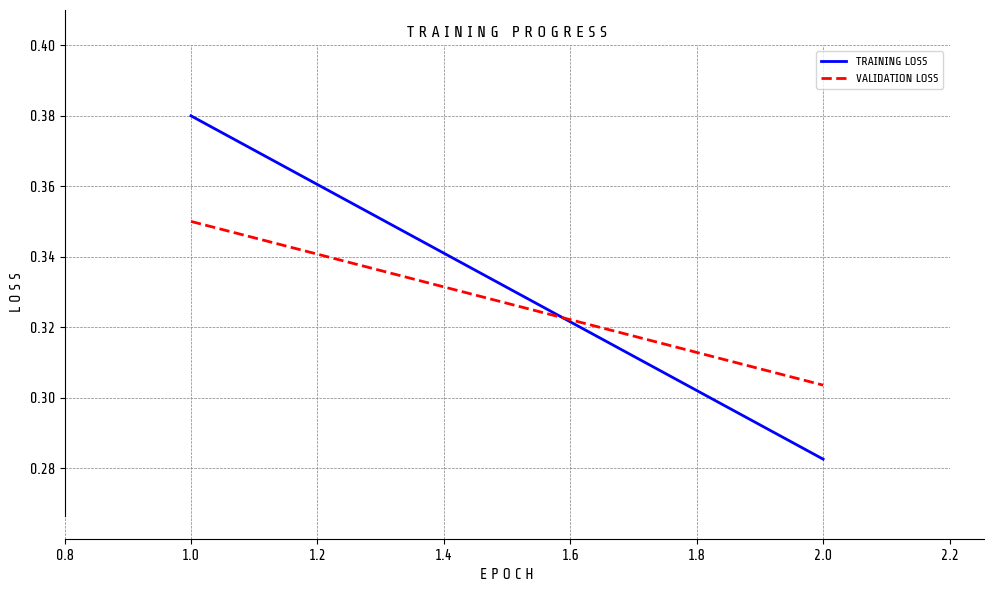

In [26]:
# Initialize the model, criterion, and optimizer

model = UNet(in_channels=3, out_channels=1).to(device)
criterion = DiceLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 2
# model = train_model(model, train_dl, valid_dl, criterion, optimizer, num_epochs)

model_v1 = utils.ml.train_model(
    model=model,
    criterion=criterion,
    optimiser=optimiser,
    train_loader=train_dl,
    val_loader=valid_dl,
    num_epochs=num_epochs,
    early_stopping=True,
    patience=3,
    save_path= Path.cwd() / "my_models" / "se05_model_v1.pt",
    plot_loss=True,
)

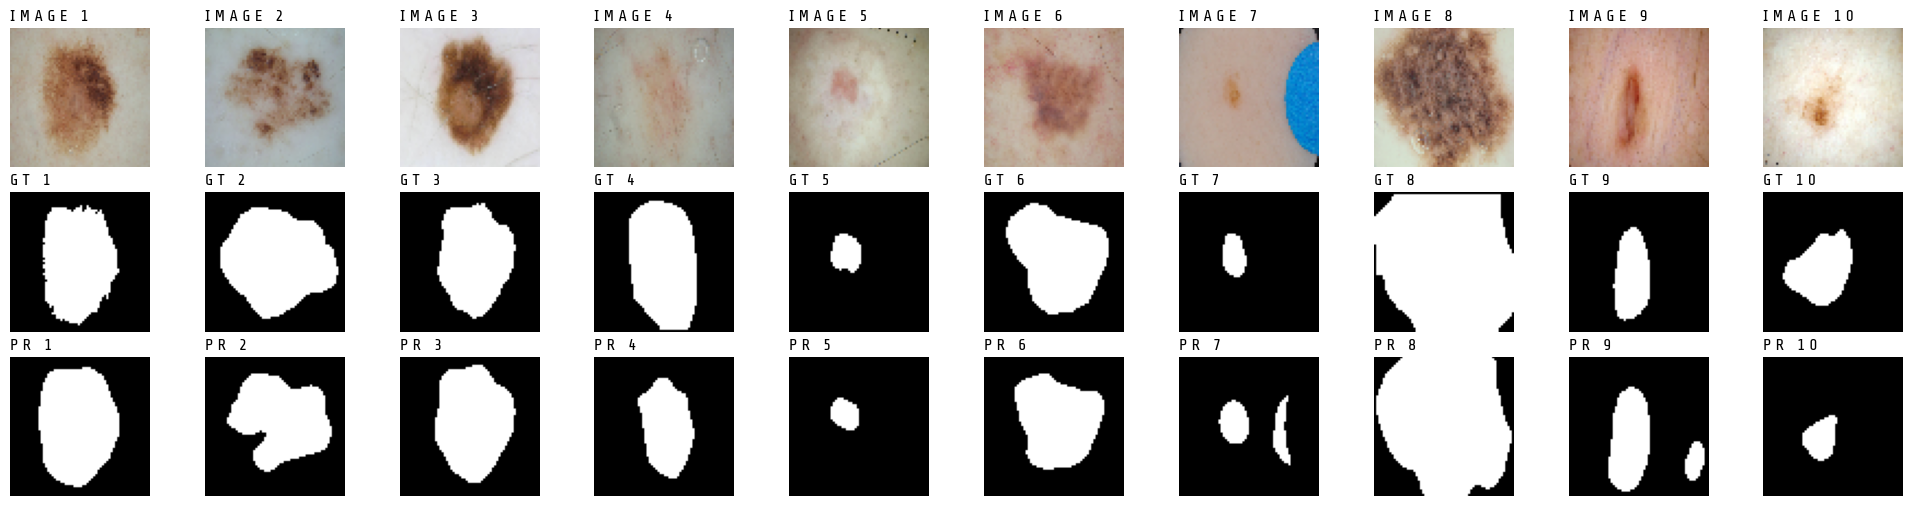

In [31]:
# Show a batch of images and masks
test_ds = ISICDatasetAlbumentations(
    image_dir=test_path,
    mask_dir=test_mask_path,
    transform=valid_img_ts
)
test_dl = DataLoader(test_ds, batch_size=16, shuffle=True)

utils.plotting.show_binary_segmentation_predictions(model_v1, test_dl, n_images=10, mean=mean, std=std)

# 5. Transfer Learning with Pre-trained Models
***
In essence, the process of transfer learning involves taking a model that has been trained on a large dataset (the source domain) and adapting it to a new, smaller dataset (the target domain). This is done by reusing the learned features from the source model and fine-tuning them for the target task. The most common approach is to use the pre-trained model as a feature extractor, where the lower layers of the model are frozen and using a classifier head that is trained on the new dataset.

The process can be visualized as follows:

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <img src="figs/transfer_custom.png" alt="Transfer Learning" style="width: 60%; height: auto; margin: 0 auto;">
</figure>

## 5.1 Pre-trained Models for Computer Vision
***

Several pre-trained models are available for computer vision tasks. Each has its own architecture, number of parameters, and performance characteristics:

| Model | Parameters | Input Size | Year | Top-1 Accuracy (ImageNet) | Architecture Highlights |
|-------|------------|------------|------|---------------------------|-------------------------|
| **ResNet** | 11.7M - 60M | 224×224 | 2015 | 76.1% - 80.6% | Residual connections to combat vanishing gradients |
| **VGG** | 138M - 144M | 224×224 | 2014 | 71.3% - 75.6% | Simple architecture with small filters (3×3) |
| **Inception** | 6.8M - 54M | 299×299 | 2014 | 77.5% - 82.8% | Multi-scale processing with parallel paths |
| **DenseNet** | 8M - 44M | 224×224 | 2017 | 74.5% - 79.5% | Dense connections between layers for feature reuse |
| **EfficientNet** | 5.3M - 66M | 224×224 - 600×600 | 2019 | 78.8% - 85.7% | Balanced scaling of depth, width, and resolution |
| **MobileNet** | 4.2M - 6.9M | 224×224 | 2017 | 70.6% - 75.2% | Designed for mobile devices with depthwise separable convolutions |

In this section, we are going to use a pre-trained model for the segmentation task. We are going to use an EfficientNet model that has been pre-trained on the ImageNet dataset. The EfficientNet model is a state-of-the-art convolutional neural network architecture that achieves high accuracy with fewer parameters compared to other architectures. 


<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <img src="figs/efficient.png" alt="EfficientNet Architecture" style="width: 80%; height: auto; margin: 0 auto;">
</figure>


## 5.2 Transfer Learning Process
***

The typical transfer learning workflow consists of these steps:

| Step | Description | Technique |
|------|-------------|-----------|
| **1. Select Source Model** | Choose a pre-trained model relevant to your target task | Select models trained on large datasets like ImageNet |
| **2. Feature Extraction** | Use the pre-trained model as a fixed feature extractor | Freeze pre-trained layers, replace and retrain output layers |
| **3. Fine-tuning** | Carefully adapt pre-trained weights to the new task | Gradually unfreeze layers, train with lower learning rates |
| **4. Model Adaptation** | Modify architecture if needed for the target task | Add or remove layers as needed for the new domain |


## 5.3 Types of Transfer Learning
***

There are several approaches to implementing transfer learning:

| Approach | Description | Best Used When |
|----------|-------------|---------------|
| **Feature Extraction** | Freeze pre-trained network, replace and retrain classifier | Target task is similar but dataset is small |
| **Fine-Tuning** | Retrain some or all layers of pre-trained network | Target task has sufficient data but benefits from pre-training |
| **One-shot Learning** | Learn from just one or very few examples | Extreme data scarcity |
| **Domain Adaptation** | Adapt to new data distribution without labels | Source and target domains have distribution shift |
| **Multi-task Learning** | Train model on multiple related tasks simultaneously | Related tasks can benefit from shared representations |

## 5.4 EfficientNet as an Encoder
***

The EfficientNet model is going to act as the encoder part of the U-Net architecture. We are going to replace the encoder part of the U-Net architecture with the EfficientNet model. The decoder part of the U-Net architecture will remain the same.

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <img src="figs/unet_efficient.png" alt="EfficientNet Architecture" style="width: 80%; height: auto; margin: 0 auto;">
</figure>


### 5.4.1 Transfer Learning Process for Segmentation
***
| Step | Description | Implementation Detail |
|------|-------------|----------------------|
| **1. Extract Encoder** | Use pre-trained EfficientNet as encoder | Remove classification head |
| **2. Add Decoder** | Create U-Net style decoder | Transposed convolutions with skip connections |
| **3. Freeze Weights** | Prevent pre-trained encoder from changing | Set `requires_grad=False` on encoder layers |
| **4. Train Decoder** | Train only the decoder initially | Optimize only unfrozen parameters |
| **5. Fine-tune (Optional)** | Gradually unfreeze encoder layers | Use lower learning rate for pre-trained layers |
***
> <img src="figs/icons/code.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(2000%) hue-rotate(40deg) brightness(915%) contrast(100%);"/> **Snippet 4**: Loading the EfficientNet model and freezing layers

``` python
from torchvision import models as tvm

efficientnet = tvm.efficientnet_b0(weights='IMAGENET1K_V1')
efficientnet = efficientnet.features  # Extract the feature extractor part
efficientnet = torch.nn.Sequential(*list(efficientnet.children())[:-1])  # Remove the classification head

for param in efficientnet.parameters():
    param.requires_grad = False  # Freeze all layers
```

In [32]:
# Exercise 11: Implementing U-Net with EfficientNet Encoder 🎯
# Implement:
# 1. Create a new Up class called SmartUp that inherits from nn.Module.
# 2. The constructor should take in the number of input channels, skip channels, and output channels.
# 3. Implement the forward method to apply a transposed convolution followed by the DoubleConv block.
# 4. Ensure to concatenate the feature maps from the encoder and decoder paths.
# 5. Handle the case where the sizes of the feature maps do not match by interpolation.
# 6. Use the torch.nn.functional.interpolate function to resize the feature maps before concatenation.
# 7. Use the torchvision.models.efficientnet_b0 model as the encoder.
# 8. Extract the feature layers from the EfficientNet model and use them in the UNet architecture.
# 9. Freeze the encoder layers to preserve the pretrained weights.
# 10. Use the DoubleConv block for the center bottleneck and decoder path.
# 11. Ensure to include skip connections between the encoder and decoder paths.
# 12. Use a final convolutional layer to produce the output.
# 13. Apply a sigmoid activation function to the output layer.

import torchvision.models as tvm

class SmartUp(torch.nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(SmartUp, self).__init__()
        self.up = torch.nn.ConvTranspose2d(in_channels, skip_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(skip_channels * 2, out_channels)  # *2 because we'll concatenate skip connection

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # Handle size mismatches with interpolation
        if x1.size()[2:] != x2.size()[2:]:
            x1 = torch.nn.functional.interpolate(x1, size=x2.size()[2:], mode='bilinear', align_corners=False)
        
        # Concatenate skip connection
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
class UNetEfficient(torch.nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNetEfficient, self).__init__()
        
        # Load pretrained EfficientNet (using B0 for efficiency)
        efficient_net = tvm.efficientnet_b0(weights='DEFAULT')
        
        # Extract feature layers from EfficientNet - using UNet nomenclature
        self.inc = torch.nn.Sequential(*list(efficient_net.features)[:2])  # Initial block
        self.down1 = efficient_net.features[2]                         # MBConv block 2
        self.down2 = efficient_net.features[3]                         # MBConv block 3
        self.down3 = efficient_net.features[4]                         # MBConv block 4
        self.down4 = torch.nn.Sequential(                              # MBConv blocks 5,6,7
            efficient_net.features[5],
            efficient_net.features[6],
            efficient_net.features[7]
        )
        
        # Freeze encoder layers to preserve pretrained weights
        encoders = [self.inc, self.down1, self.down2, self.down3, self.down4]
        for encoder in encoders:
            for param in encoder.parameters():
                param.requires_grad = False
        
        # Get the output channels from each encoder stage
        enc1_channels = 16     # Initial block outputs 16 channels
        enc2_channels = 24     # MBConv block 2 outputs 24 channels
        enc3_channels = 40     # MBConv block 3 outputs 40 channels
        enc4_channels = 80     # MBConv block 4 outputs 80 channels
        enc5_channels = 320    # Last MBConv block outputs 320 channels
        
        # Center bottleneck (using DoubleConv)
        self.center = DoubleConv(enc5_channels, 512)
        
        # Upsampling path with SmartUp blocks - now using UNet nomenclature (up1-4)
        self.up1 = SmartUp(512, enc4_channels, enc4_channels)
        self.up2 = SmartUp(enc4_channels, enc3_channels, enc3_channels)
        self.up3 = SmartUp(enc3_channels, enc2_channels, enc2_channels)
        self.up4 = SmartUp(enc2_channels, enc1_channels, enc1_channels)
        
        # Final output layer - matches UNet's outc
        self.outc = torch.nn.Conv2d(enc1_channels, out_channels, kernel_size=1)
    
    def forward(self, x):
        # Save input size for later resizing if needed
        input_size = x.size()[2:]
        
        # Encoder path with EfficientNet - using UNet nomenclature
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # Center processing
        x = self.center(x5)
        
        # Decoder path with skip connections - using UNet nomenclature
        x = self.up1(x, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        # Final output layer
        output = self.outc(x)
        
        # Resize to match original input dimensions if needed
        if output.size()[2:] != input_size:
            output = torch.nn.functional.interpolate(output, size=input_size, mode='bilinear', align_corners=False)
        
        return torch.nn.functional.sigmoid(output)



UNetEfficient Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training Batch 0/45:   0%|          | 0/45 [00:00<?, ?it/s]

Validation Batch 0/12:   0%|          | 0/12 [00:00<?, ?it/s]

Training Batch 0/45:   0%|          | 0/45 [00:00<?, ?it/s]

Validation Batch 0/12:   0%|          | 0/12 [00:00<?, ?it/s]

Training Batch 0/45:   0%|          | 0/45 [00:00<?, ?it/s]

Validation Batch 0/12:   0%|          | 0/12 [00:00<?, ?it/s]

Training Batch 0/45:   0%|          | 0/45 [00:00<?, ?it/s]

Validation Batch 0/12:   0%|          | 0/12 [00:00<?, ?it/s]

Training Batch 0/45:   0%|          | 0/45 [00:00<?, ?it/s]

Validation Batch 0/12:   0%|          | 0/12 [00:00<?, ?it/s]

Best model saved at c:\Users\Corona\Documents\Git\UoM_fse_dl_workshop\my_models\se05_model_v2.pt


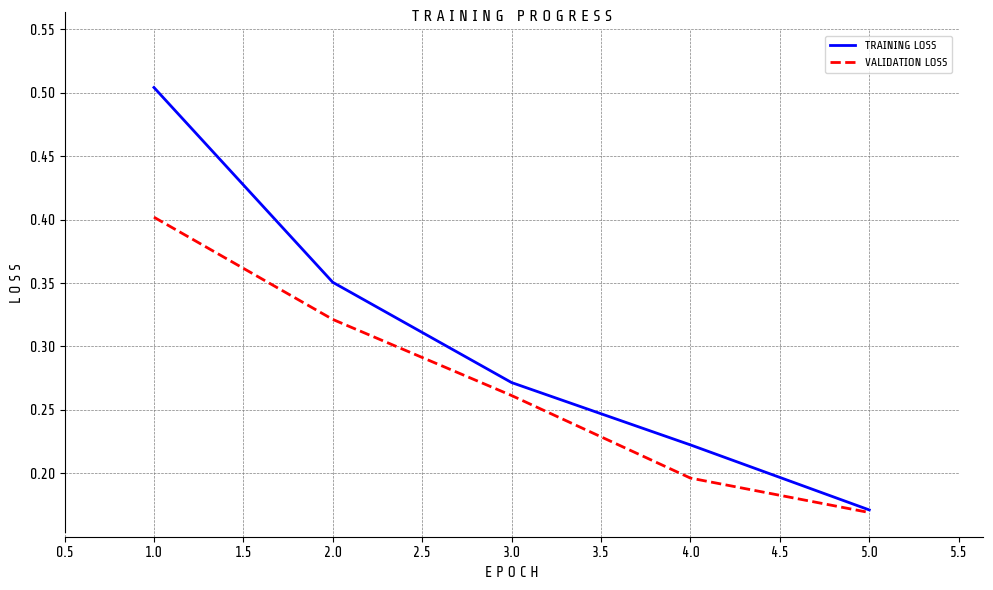

In [33]:
# Initialize the EfficientNet UNet model
model_efficient = UNetEfficient(in_channels=3, out_channels=1).to(device)
criterion_efficient = DiceLoss()
optimizer_efficient = torch.optim.Adam(filter(lambda p: p.requires_grad, model_efficient.parameters()), lr=1e-3)

num_epochs = 5

model_efficient = utils.ml.train_model(
    model=model_efficient,
    criterion=criterion_efficient,
    optimiser=optimizer_efficient,
    train_loader=train_dl,
    val_loader=valid_dl,
    num_epochs=num_epochs,
    early_stopping=True,
    patience=3,
    save_path= Path.cwd() / "my_models" / "se05_model_v2.pt",
    plot_loss=True,
)

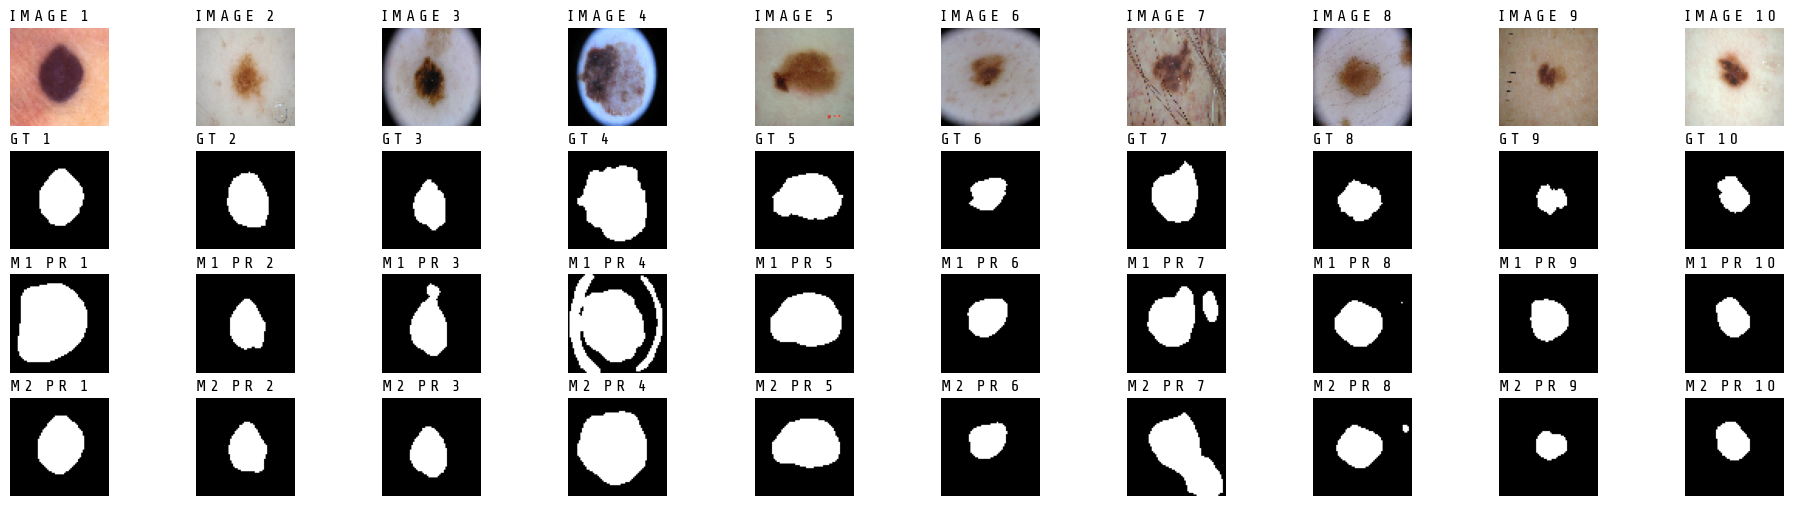

In [42]:
# Visualize predictions with EfficientNet UNet
utils.plotting.compare_binary_segmentation_models(
    model_v1, model_efficient, test_dl, n_images=10, mean=mean, std=std)

## 5.5 Advantages of Transfer Learning
***
Transfer learning is particularly effective in computer vision and natural language processing (NLP) tasks, where large pre-trained models are available. The key advantages of transfer learning include:

| Advantage | Description | Impact |
|-----------|-------------|--------|
| **Reduced Training Time** | Start with pre-learned features instead of random weights | Training can be 5-10x faster than from scratch |
| **Less Training Data** | Leverage knowledge from the source domain | Can work with hundreds vs. thousands of examples |
| **Better Performance** | Often achieves higher accuracy than training from scratch | Especially beneficial with limited target data |
| **Faster Convergence** | Models typically reach optimal performance in fewer epochs | Reduces computational costs of model development |
| **Lower Computational Cost** | Requires fewer resources for training | Makes deep learning accessible with limited hardware |
| **Knowledge Retention** | Preserves useful features learned from large datasets | Captures generalizable representations across domains |


In [35]:
# Quiz on Transfer Learning Concepts
print("\n🧠 Quiz 2: Feature extraction vs. Fine Tuning")
quizzer.run_quiz(2)

print("\n🧠 Quiz 3: Selecting Pre-trained models")
quizzer.run_quiz(3)

print("\n🧠 Quiz 4: Transfer Learning Techniques")
quizzer.run_quiz(4)

print("\n🧠 Quiz 5: Transfer Learning Learning Rate Selection")
quizzer.run_quiz(5)


🧠 Quiz 2: Feature extraction vs. Fine Tuning
--------------------------------------------------------------------------------
📋 Feature Extraction vs Fine-Tuning Quiz
--------------------------------------------------------------------------------
For a materials science dataset with only 500 samples of microstructure images, which transfer learning approach would likely be most appropriate?

A. Training from scratch (no transfer learning)

B. Fine-tuning all layers of a pre-trained model

C. Feature extraction with a frozen pre-trained backbone

D. Using the pre-trained model without any modifications


❌ Incorrect. The correct answer is C.

📚 Explanation:
Feature extraction with a frozen pre-trained backbone is typically the best
approach for small datasets like the materials science example with only 500
samples. When using feature extraction, the pre-trained network layers are kept
frozen (weights aren't updated), and only the new classification layers are
trained. This approach p